# 1. Load data

I load the dataset and split it into dictionaries by position which is going to simplify some genetic operations.

In [1]:
import pandas as pd

df = pd.read_pickle("data/final_data.pkl")

pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None


def split_players_by_position(df):
    """Split players by position for easy filtering"""
    
    players_by_position = {
        "GK": df[df["position"] == "GK"].to_dict("records"),
        "DEF": df[df["position"] == "DEF"].to_dict("records"),
        "MID": df[df["position"] == "MID"].to_dict("records"),
        "FWD": df[df["position"] == "FWD"].to_dict("records"),
    }

    return players_by_position

# 2. Define function to create individuals

Since we need to obey the player selection rules it is easier to nudge the algorithm in the right direction and let it work on valid individuals in terms of player positions. We could let the algorithm figure this out on its own but this would waste too much time and resources.

Obeying the squad selection constraints:

Initial squad rules:
- Max 1000 cost.
- Max 15 players.
- Max 3 players from the same team.
- 2 GKs
- 5 DEFs
- 5 MIDs
- 3 FWDs

In [ ]:
import random
from deap import base, creator, tools, algorithms

def create_individual():
    """Generate a valid squad of 15 players following constraints."""
    squad = []

    squad += random.sample(players_by_position["GK"], 2)
    squad += random.sample(players_by_position["DEF"], 5)
    squad += random.sample(players_by_position["MID"], 5)
    squad += random.sample(players_by_position["FWD"], 3)

    return squad


# Define fitness function - maximization problem
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# Individual will be a list of chromosomes
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
# Register create_individual function as a creator function
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
# Population will be a list of created individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 3. Define the fitness function for evaluation

This function is going to evaluate each individual and make sure that the individuals obey the constraints of maximum value and maximum players from 1 team.

In [3]:
def evaluate(individual):
    """Fitness function: maximize expected points while enforcing constraints.
        Returns 0 to penalize solutions which disobey the constraints.
    """
    # All players need to be unique
    cnt_unique_players = len(set(player["name"] for player in individual))
    # Budget constraint
    total_value = sum(player["value"] for player in individual)

    if (cnt_unique_players != 15) or (total_value > 1000):
        return (0,)

    # Max 3 players from the same team constraint
    team_counts = {}
    for player in individual:
        team_counts[player["team"]] = team_counts.get(player["team"], 0) + 1
        if team_counts[player["team"]] > 3:
            return (0,)
        
    # Weighs
    w_xP = 1; w_xG = 1; w_xA = 1; w_xGI = 1; w_xGC = -1; w_fd = -1; w_roll = 1

    total_score = sum(
        w_xP * player["xP_inter"]
        + w_xG * player["expected_goals"]
        + w_xA * player["expected_assists"]
        + w_xGI * player["expected_goal_involvements"]
        + w_xGC * player["expected_goals_conceded"]
        + w_fd * player['fix_difficulty']
        + w_roll * player['rolling_total_points_3gw']
        for player in individual
    )

    return (total_score,)


# Register evaluation function
toolbox.register("evaluate", evaluate)

# 4. Define functions for crossover and mutation

Custom functions for crossover and mutation need to be defined because we need to ensure that the positions of players will stay such that they respect the constraints even after mating (crossover) and mutation.

In [4]:
# Register built-in tournament selection
toolbox.register("select", tools.selTournament, tournsize=3)


def cx_swap_same_position(individual1, individual2):
    """
    Custom crossover that swaps players of the same position
    to maintain the squad structure.
    """
    for pos_group in ["GK", "DEF", "MID", "FWD"]:
        pos_indices = [
            i
            for i in range(len(individual1))
            if individual2[i]["position"] == pos_group
        ]
        # If the list is not empty
        if pos_indices:
            swap_idx = random.choice(
                pos_indices
            )
            # Swapping individuals
            individual1[swap_idx], individual2[swap_idx] = (
                individual2[swap_idx],
                individual1[swap_idx],
            )
    return individual1, individual2


# Register custom crossover function
toolbox.register("mate", cx_swap_same_position)

players_by_position = 'x'

def mut_replace_same_position(individual):
    """
    Custom mutation which replaces a player while maintaining 
    the position structure.
    """
    # Select a random player index and get their position
    pos_to_replace = random.randint(
        0, len(individual) - 1
    )  

    position = individual[pos_to_replace]["position"]  
    # Pick a new player from the same position
    new_player = random.choice(
        players_by_position[position]
    )  

    individual[pos_to_replace] = new_player
    return (individual,)


# Register custom mutation function
toolbox.register("mutate", mut_replace_same_position)

# 5. Define function to run the GA 

In [5]:
def run_ga(n_individuals, n_generations):
    """Run the Genetic Algorithm using DEAP's built-in tools."""
    population = toolbox.population(n=n_individuals)
    # Use simple GA, set probability of crossover, mutation and number of generations
    algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=n_generations, verbose=False)

    # Get the best squad
    best_squad = tools.selBest(population, 1)[0]
    return best_squad

In [6]:
from deap import base, creator, tools, algorithms
import random


def run_ga_with_stagnation():
    """Run GA with stagnation-based early stopping."""
    
    stagnation_limit = 20 
    stagnation_counter = 0
    best_fitness = -float("inf")
    ngen = 500
    population = toolbox.population(n=ngen)  # Initialize population
    # Max number of generations
    cxpb = 0.7  # Crossover probability
    mutpb = 0.2  # Mutation probability

    for gen in range(ngen):

        # Apply selection, crossover, mutation
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        # Apply mutation
        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate new fitnesses
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace old population with new offspring
        population[:] = offspring

        # Get the best fitness of the current generation
        current_best = max(ind.fitness.values[0] for ind in population)

        # Check for stagnation
        if current_best > best_fitness:
            best_fitness = current_best 
            stagnation_counter = 0  
        else:
            stagnation_counter += 1 

        if stagnation_counter >= stagnation_limit:
            print(f"GA stopped early at generation {gen} due to stagnation.")
            break

    best_squad = tools.selBest(population, 1)[0]
    return best_squad

In [7]:
from deap import base, creator, tools, algorithms
import random


def run_ga_with_stagnation_simple(n_individuals, n_generations, stagnation_limit=20):
    """Run the Genetic Algorithm with stagnation-based early stopping."""

    convergence_stats = {
        "generation": [],
        "current_best": [],
    }

    population = toolbox.population(n=n_individuals)
    best_fitness = -float("inf")  # Best fitness seen so far
    stagnation_counter = 0  # Count generations without improvement

    for gen in range(n_generations):
        # Run one generation of the GA
        population, logbook = algorithms.eaSimple(
            population, toolbox, cxpb=0.7, mutpb=0.2, ngen=1, verbose=False
        )

        # Get the best fitness of the current generation
        current_best = max(ind.fitness.values[0] for ind in population)

        convergence_stats["generation"].append(gen + 1)
        convergence_stats["current_best"].append(current_best)

        # Check if fitness has improved
        if current_best > best_fitness:
            best_fitness = current_best
            stagnation_counter = 0  # Reset stagnation counter
        else:
            stagnation_counter += 1  # Increase stagnation count

        # If stagnation limit reached, stop the GA early
        if stagnation_counter >= stagnation_limit:
            print(f"GA stopped early at generation {gen + 1} due to stagnation.")
            break

    # Get the best squad
    best_squad = tools.selBest(population, 1)[0]
    return best_squad, convergence_stats

# 6. Define brute-force function to select the final 11 



In [8]:
from itertools import combinations


def find_best_starting_11(squad):
    """
    Finds the best valid starting 11 lineup from the 15-man squad.
    Using a brute-force combinations algorithm. 
    """

    best_lineup = None
    best_score = 0

    # Generate all possible 11-player lineups from the 15-man squad
    for lineup in combinations(squad, 11):
        lineup = list(lineup) 

        # Count positions
        pos_counts = {"GK": 0, "DEF": 0, "MID": 0, "FWD": 0}
        for player in lineup:
            pos_counts[player["position"]] += 1

        # Check position constraints
        if pos_counts["GK"] != 1:
            continue 
        if pos_counts["DEF"] < 3:
            continue 
        if pos_counts["FWD"] < 1:
            continue 

        # Calculate total expected points
        lineup_points = sum(player["xP_inter"] for player in lineup)

        if lineup_points > best_score:
            best_score = lineup_points
            best_lineup = lineup

    return best_lineup

# 7. Run the model

Running the model for 38 GWs and 30 seasons - these iterations enable us to calculate average results since the model is stochastic and non-deterministic.

In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm
import time
from numpy import std

df_totw = pd.read_pickle('data/df_totw.pkl')

with open("data/totw_points.txt", "r") as file:
    totw_points = [int(line.strip()) for line in file]


season_results = {
    "season": [],
    "GW": [],
    "rmse": [],
    "mae": [],
    "mape": [],
    "total_points": [],
    "xP": [],
    "totw_points": [],
    "squad_value": [],
    "time_infer": [],
    "totw_overlap": [],
    "std_intra": [],
}

squads = {
    "season": [],
    "GW": [],
    "squad": [],
}

convergence_results = {
    "season": [],
    "GW": [],
    "generation": [],
    "current_best": []
}

# run 30 times
for j in tqdm(range(30)):
    pred_points = []


    for i in tqdm(range(max(df['GW']))):
        players_by_position = split_players_by_position(df[df['GW'] == (i + 1)])

        start = start_time = time.time()
        result = run_ga_with_stagnation_simple(100,200,20)
        infer_time = time.time() - start_time

        best_squad = result[0]
        convergence_stats = result[1]
        convergence_stats["season"] = len(convergence_stats["generation"]) * [j + 1]
        convergence_stats["gw"] = len(convergence_stats["generation"]) * [i + 1]

        convergence_results['generation'] += convergence_stats['generation']
        convergence_results["current_best"] += convergence_stats["current_best"]
        convergence_results["season"] += convergence_stats["season"]
        convergence_results["GW"] += convergence_stats["gw"]


        best_squad_df = pd.DataFrame(find_best_starting_11(best_squad))


        total_points = sum(best_squad_df['total_points'])

        pred_points.append(total_points)

        mse = root_mean_squared_error(totw_points[:i+1], pred_points)
        mae = mean_absolute_error(totw_points[:i+1], pred_points)
        mape = mean_absolute_percentage_error(totw_points[:i+1], pred_points)


        common_rows = df_totw[df_totw['GW'] == i + 1].merge(best_squad_df, how='inner')
        overlap_pct = (len(common_rows)/11)

        sd_intra = std(best_squad_df['total_points'])

        season_results['std_intra'].append(sd_intra)
        season_results['totw_overlap'].append(overlap_pct)
        season_results["season"].append(j + 1)
        season_results["GW"].append(i + 1)
        season_results["rmse"].append(mse)
        season_results["mae"].append(mae)
        season_results["mape"].append(mape)
        season_results["total_points"].append(total_points)
        season_results["xP"].append(sum(best_squad_df['xP_inter']))
        season_results["totw_points"].append(totw_points[i])
        season_results["time_infer"].append(infer_time)
        season_results["squad_value"].append(sum(best_squad_df["value"]))

        squads["season"].append(j + 1)
        squads["GW"].append(i + 1)
        squads['squad'].append(best_squad_df)
        

        print(

            f"GW{i+1}, exp. points: {sum(best_squad_df['xP_inter'])}, total points: {total_points}, TOTW points: {totw_points[i]}, RMSE: {mse}"
        )

In [ ]:
# Parse players squads results dictionary into pd dataframe

df_players = pd.DataFrame(squads_all['squad'][0])
df_players['season'] = squads_all['season'][0]
df_players['GameWeek'] = squads_all['GW'][0]

for i in range(1,1140):
    df_new = pd.DataFrame(squads_all['squad'][i])
    df_new['season'] = squads_all['season'][i]
    df_new['GameWeek'] = squads_all['GW'][i]                     
    
    df_players = pd.concat([df_players, df_new])

df_ga_avg_squad = df_season_results.groupby('GW').mean()

# df_ga_avg_squad.to_pickle('ga_results/ga_avg_squad.pkl')
# df_players.to_pickle('ga_results/ga_squads_all_runs.pkl')

In [ ]:
# Save results
# df_season_results = pd.DataFrame(season_results)
# df_season_results.to_pickle("ga_results/season_results.pkl")

# df_convergence_results = pd.DataFrame(convergence_results)
# df_convergence_results.to_pickle("ga_results/convergence_results.pkl.pkl")

# Load results

df_season_results = pd.read_pickle('ga_results/df_season_results.pkl')
df_convergence_results = pd.read_pickle('ga_results/df_convergence_results.pkl')
df_ga_avg_squad = pd.read_pickle('ga_results/ga_avg_squad.pkl')
df_all_run_squad = pd.read_pickle('ga_results/ga_squads_all_runs.pkl')

# 8. Calculate statistics about the runs

Utilize saved dataframes that contains statistics about each GW and each run to calculated averages over the runs and evaluate the algorithms. Also using statistics about convergence we evaluate how quickly the GA converges for each GW.

In [30]:
convergence = {
    'season': [],
    'gw' : [],
    'converged_in_gen': []
}
for i in range(1, 31):
    for j in range(1, 39):    

        convergence['season'].append(i)
        convergence['gw'].append(j)
        convergence["converged_in_gen"].append(df_convergence_results[
            (df_convergence_results["season"] == i) & (df_convergence_results["GW"] == j)
        ]["generation"].max())

df_convergence = pd.DataFrame(convergence)

In [31]:
avg_conv_by_gw = {
    'gw':[],
    'avg_convergence':[]
}

for gw in range(1, 39):
    avg_conv_by_gw["gw"].append(gw)
    avg_conv_by_gw["avg_convergence"].append(
        df_convergence[df_convergence["gw"] == gw]["converged_in_gen"].mean()
    )

pd.DataFrame(avg_conv_by_gw).head()

,gw,avg_convergence
0,1,111.766667
1,2,111.600000
2,3,103.733333
3,4,97.966667
4,5,102.566667


In [33]:
from statistics import stdev

print(
"avg: ", round(df_season_results[df_season_results["GW"] == 38]["rmse"].mean(), 2),"\n",
"min: ", round(df_season_results[df_season_results["GW"] == 38]["rmse"].min(), 2),"\n",
"max: ", round(df_season_results[df_season_results["GW"] == 38]["rmse"].max(), 2),"\n",
"sd: ", round(stdev(df_season_results[df_season_results["GW"] == 38]["rmse"]), 2)
)

avg:  49.39 
 min:  45.66 
 max:  53.29 
 sd:  1.95


# 8. Visualize the run

In [34]:
# Load ideal team points
with open("data/totw_points.txt", "r") as file:
    totw_points = [int(line.strip()) for line in file]

In [35]:
# prepare data for the visualization

avg_rmse = []
avg_total_points = []

for i in range(1, 39):
    avg_total_points.append(
        df_season_results[df_season_results["GW"] == i]["total_points"].mean()
    )

    avg_rmse.append(df_season_results[df_season_results["GW"] == i]["rmse"].mean())

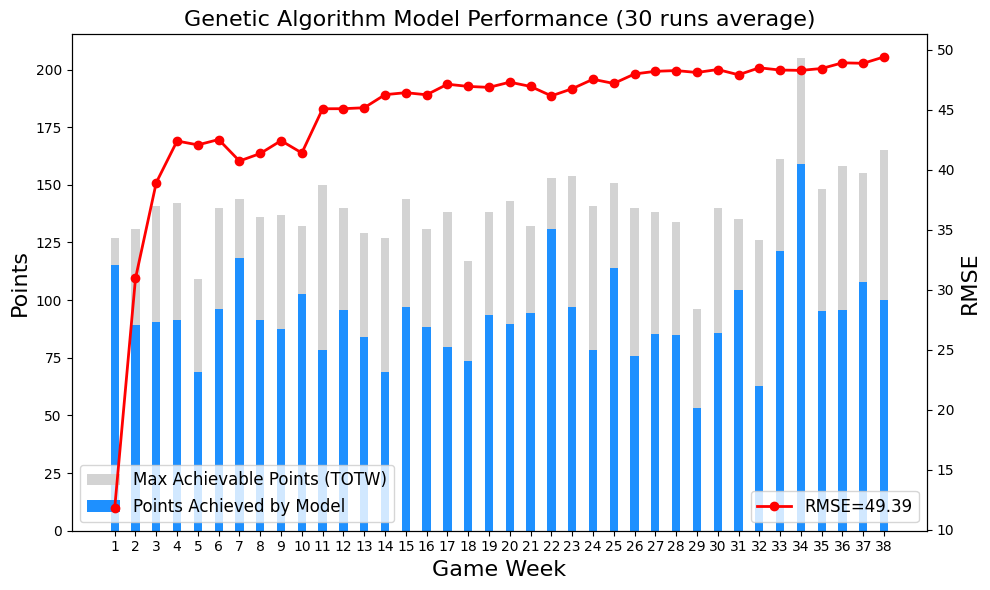

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Max achievable points (TOTW)
max_points = totw_points
indices = np.arange(1, len(max_points) + 1)
# Points achieved by the model
model_points = avg_total_points

# Plotting canvas
fig, ax1 = plt.subplots(figsize=(10, 6))
bar_width = 0.4

# Bars for max achievable points
bar1 = ax1.bar(
    indices,
    max_points,
    bar_width,
    label="Max Achievable Points (TOTW)",
    color="lightgray",
)

# Bars for model points achieved (overlapping)
bar2 = ax1.bar(
    indices,
    model_points,
    bar_width,
    label="Points Achieved by Model",
    color="dodgerblue",
)

# Secondary y-axis for RMSE
ax2 = ax1.twinx()
line = ax2.plot(indices, avg_rmse, label=f"RMSE={round(avg_rmse[-1], 2 )}", color="red", marker="o", linewidth=2)

# Labels, title, and legend
ax1.set_xlabel("Game Week", fontsize=16)
ax1.set_ylabel("Points", fontsize=16)
ax2.set_ylabel("RMSE", fontsize=16)
ax1.set_title("Genetic Algorithm Model Performance (30 runs average)", fontsize=16)
ax1.set_xticks(indices)
ax1.legend(loc="lower left", fontsize=12)
ax2.legend(loc="lower right", fontsize=12)

plt.tight_layout()
plt.show()